# Multi-pitch detection TP

*(reference: Klapuri) but with pitch detection with spectral sum

*From G. Richard (with help from P. Vernhet), MAJ:2019*

student's name: SI SALAH Imane

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil

C:\Users\imane\AppData\Local\Temp\ipykernel_29680\574563888.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Functions

In [2]:
def load_music(file):
    return wave.open(file, 'rb')


def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_


def f2idx(F, df):
    """
    Convert frequency to corresponding index in "frequencies" array
    """
    return ceil(F/df)

## 0 - Reading and playing .wav file

Choose the name of music for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'sons_multipitch')
filename = 'A4_piano.wav'
music = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_music(music)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=31994, comptype='NONE', compname='not compressed')


In [5]:
play = True
if play :
    play_music(music) 

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
print('numbre of smples;', num_samples)
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

numbre of smples; 31994


In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

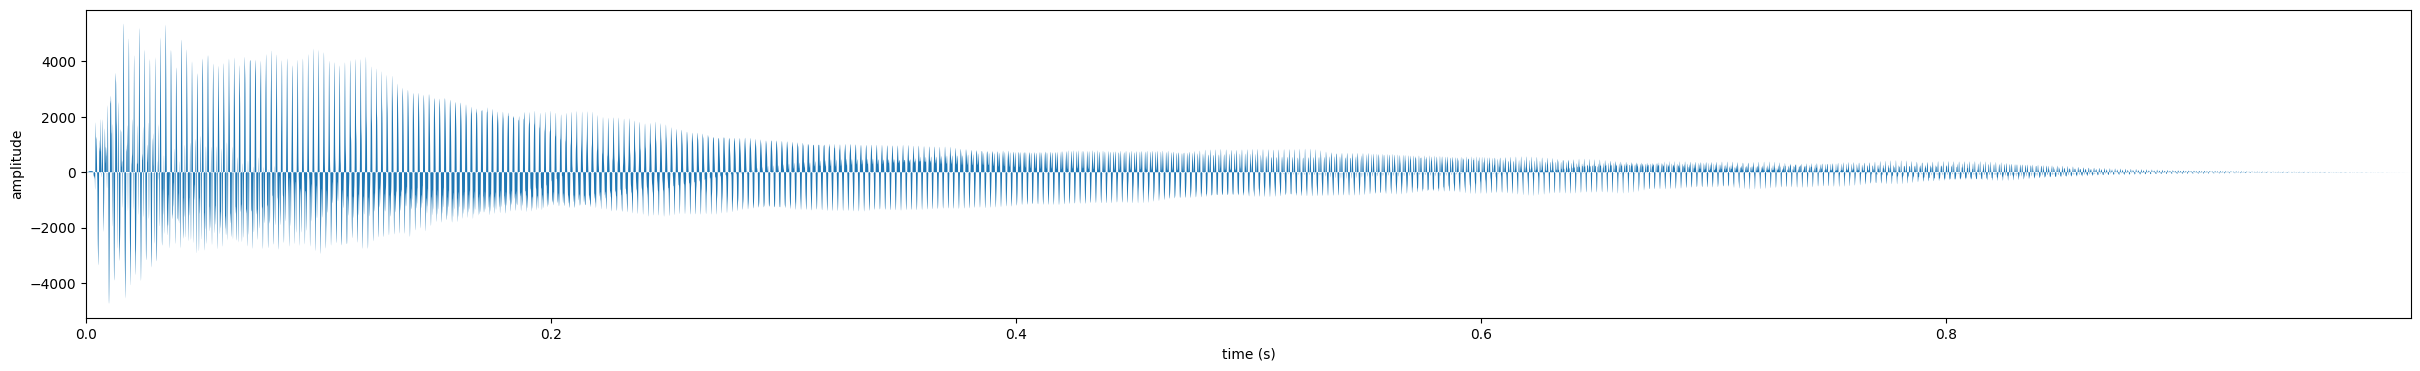

In [8]:
plot_sound(x, times)

## I - Window and Fast Fourier Transform


**1. Window size :** A Hamming window is used, its length covering $700$ ms of the entire signal 

**2. Offset :** The offset is chosen to be about $100$ ms, 

**3. Spectral precision after the FFT :** The frequency precision is given by $dF_{\text{min}}=\frac{F_{s}}{Nfft}$, where $Nfft$ is the size of the FFT window. 


In [9]:
N=ceil(0.7*Fs)       # Window size of analysed signal (only one window of signal is analysed)
dF_min=Fs/N   # Minimal frequency resolution
print('The minimal frequency resolution is of {:.2f} Hz'.format(dF_min))

The minimal frequency resolution is of 1.43 Hz


In [10]:
w=np.hamming(N)  # Window
width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
print('the witdh is ', N)
eps=float(1e-20)   #precision

the witdh is  22400


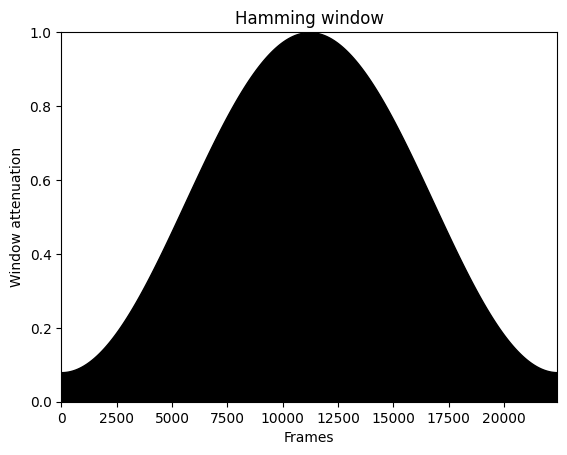

In [11]:
plt.fill_between(np.arange(len(w)), w, color='k')
plt.title('Hamming window')
plt.xlabel('Frames')
plt.ylabel('Window attenuation')
plt.xlim(0, len(w))
plt.ylim(0, 1)
plt.show()

### Discarding the attack of the sound

In [12]:
offset=ceil(0.1*Fs)
print(offset/Fs)
xw=x[offset:offset+N]*w    # xw is the analysed signal frame
n_xw = xw.size
print(n_xw)

0.1
22400


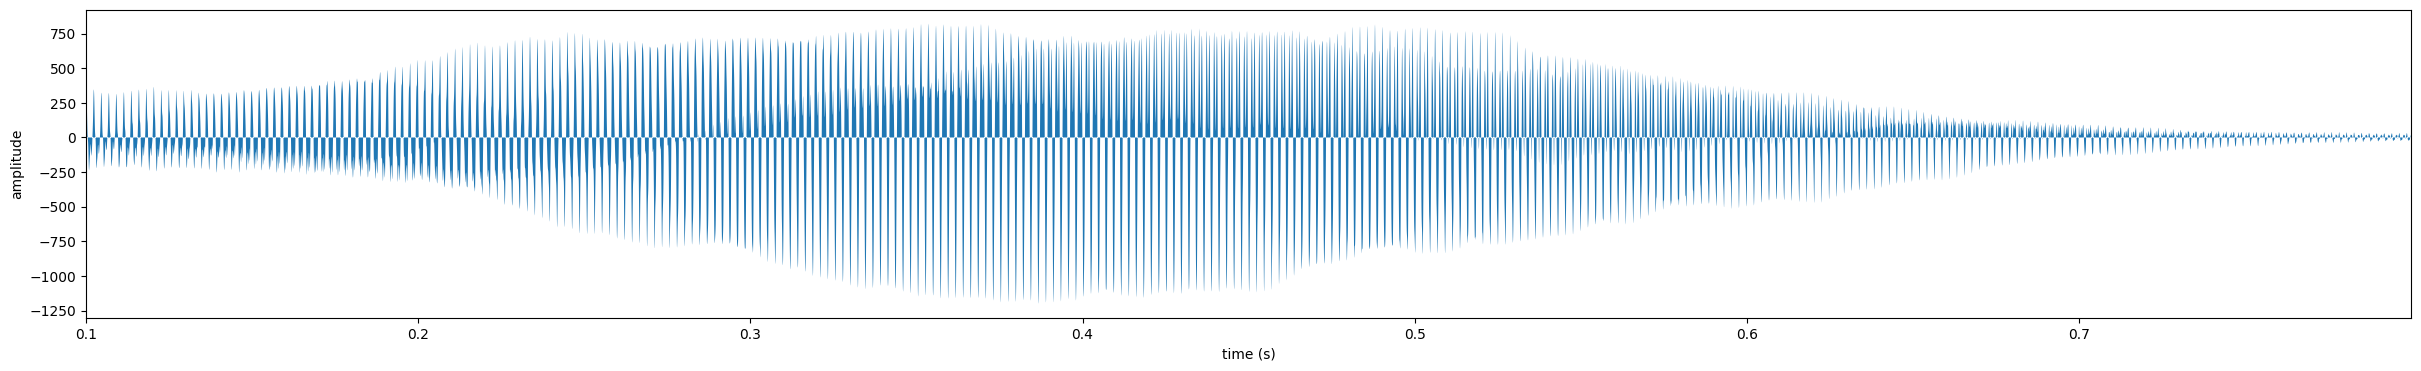

In [13]:
plot_sound(xw, times[offset:offset+N])

This is the temporal visualization of the sound we will be working on.

### Processing for efficient FFT (*by truncating to powers of 2*)

The min Nfft to get a precision of at least dFmin is computed by $Fs/dFmin$ and is: $22400$

In [14]:
#Minimal number of data points to satisfy the minimal frequency resolution
#we kniw that dF_min= Fs/N
Nfft_min=Fs/dF_min #df_min was defined before
print(Nfft_min)
#resolution vs precision du signal

#compute the smallest power of two that satisfies the minimal frequency resolution for FFT
p, Nfft = nextpow2(Nfft_min) #redefinirn nfft so that it is a power of two
print('next power',p)
print('nfft_min*p',Nfft)
x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
x_fft /= np.max(np.abs(x_fft))+eps # Normalization

print('origianl resolution: {:.2}Hz when we had {} samples'.format( dF_min, N))
df=Fs/Nfft # frequency virtual resolution of FFT 
print('Frequency virtual resolution of FFT {:.2} Hz when we have {} samplzq for fft'.format(df, Nfft))
print(len(x_fft))

22400.0
next power 15
nfft_min*p 32768
origianl resolution: 1.4Hz when we had 22400 samples
Frequency virtual resolution of FFT 0.98 Hz when we have 32768 samplzq for fft
32768


In [15]:
frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)

Plot FFT spectrum

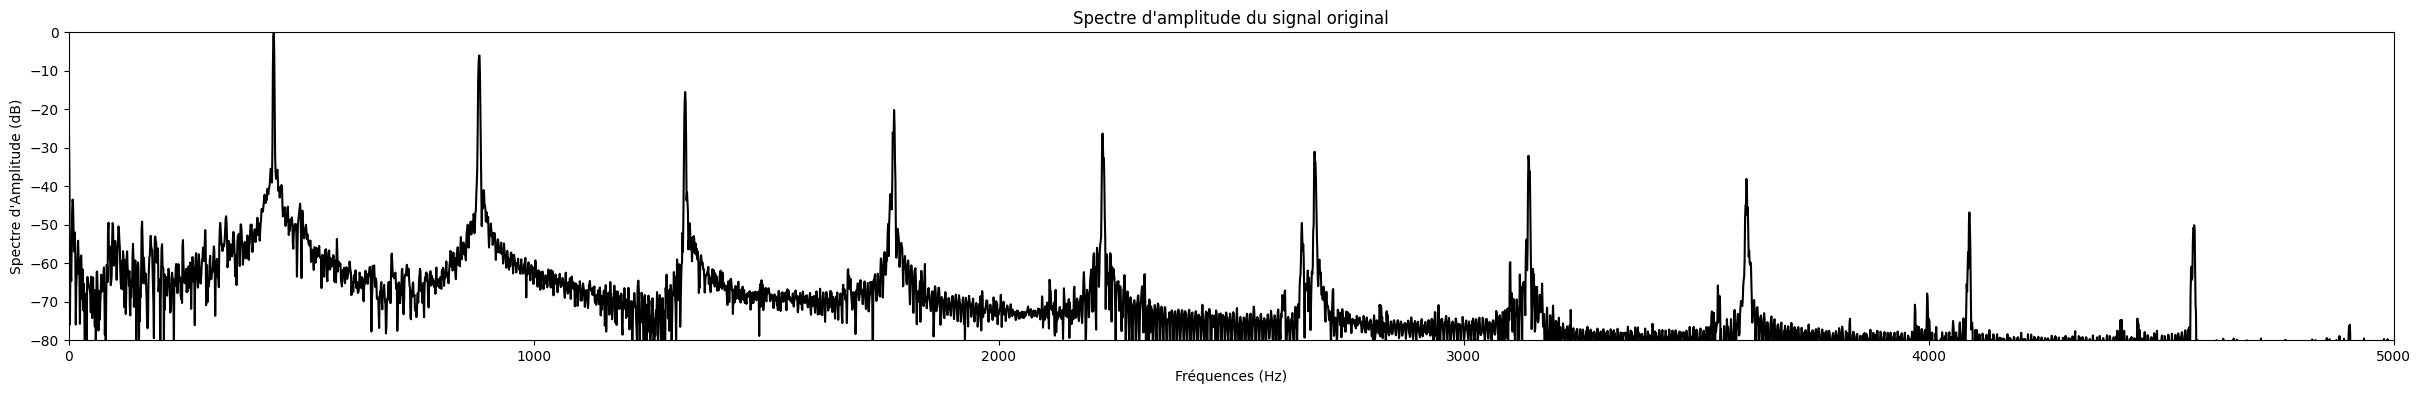

In [16]:
plt.figure(figsize=(30, 4))
plt.plot(frequencies[:int(Nfft/2)], 20*np.log10(X_fft[:int(Nfft/2)]), color='k')
plt.xlim(0, 5000)
plt.ylim(-80, 0)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title('Spectre d\'amplitude du signal original')
plt.show()

For **A4_piano.wav**, we clearly see the harmonic around $\sim 440$ Hz and partials (multiples of the fundamental frequency peak).

## II - Fundamental frequency estimation by spectral product/sum method

The different steps include :

#loop on the number of pitches
    - example criterion could use an energy ratio "while criterion > seuil_F0"
    
  #Detection of main F0
  
        -Compute spectral sum
        -locate maximum
        -store value of estimated F0

  #Subtraction of main note (Main F0 with its harmonics)
        
        -localisation of harmonics around theoretical values (with or without inharmonicy coefficient) 
        - beta: harmonicity coefficient ;  alpha: coefficient of tolerance
                
        - Harmonic suppression (wideness of an harmonic to be suppressed depends on the main lob of the TF of the analysis window); suppression of harmonics is done on abs(Xk) on forcing all values of a harmonic peak to the minimum value of the peak (e.g. the level of noise).
         
#end of loop

In [17]:
Fmin=100             # Minimal F0 frequency that can be detected
Fmax=900             # Maximal F0 frequency that can be detected
H=4                  # H = nombre de versions compressées
Rmax = ceil((Nfft-1)/(2*H)) # fréquence maximale

In [18]:
Nmin = f2idx(Fmin,df)-1
Nmax = f2idx(Fmax,df)
assert Nmax <= Rmax and Nmin >= 0

Functions sum and product

In [19]:
def spectral_sum(x, R, H):
    """
    Spectral sum
    """
    #mehod i1
    summ= np.copy(x)[:R]
    for i in range(1, H):
        down= np.copy(x)[0:R:i]
        down= np.pad(down, (0,len(summ)- len(down)), mode='constant', constant_values=0)
        summ= [x[i] + down[i] for i in range(R)]
    return summ


def spectral_method(x, R, H, method='sum'):
    """
    Factorization of previous methods
    """
    # assert method in ['sum', 'product']
    if method == 'sum':
        return spectral_sum(x, R, H)

In [20]:
spect_sum= spectral_sum(X_fft, Rmax, H)
idx= np.argmax(spect_sum[Nmin: Nmax+1])+Nmin
F0=Fs*idx/len(X_fft)
print('the fundamental frequency using spectral summ is found to be :{:.2f} Hz'.format(F0))

the fundamental frequency using spectral summ is found to be :441.41 Hz


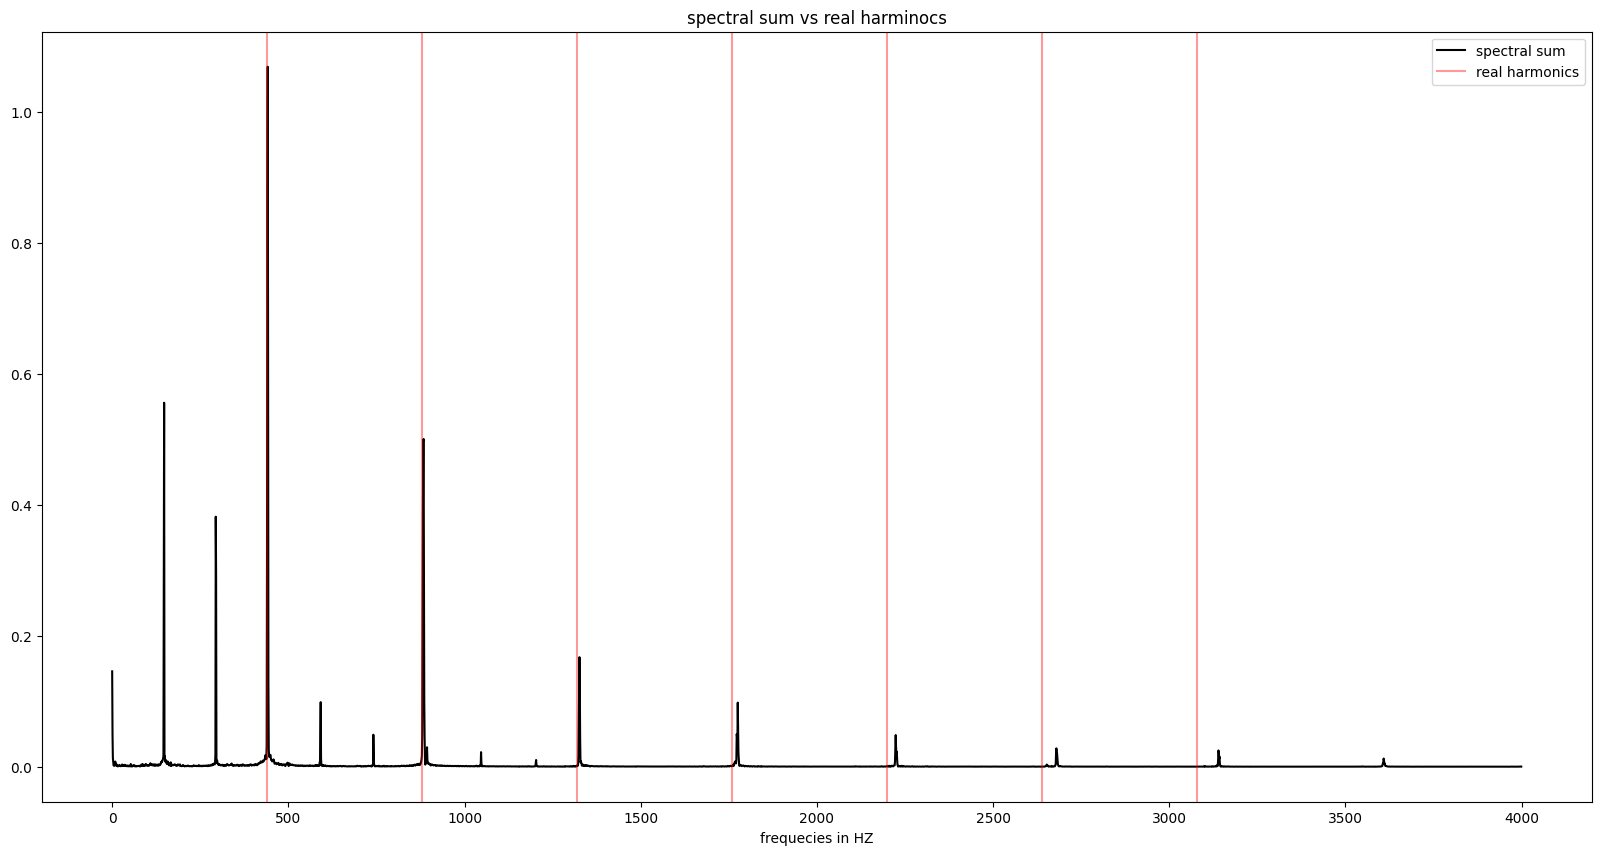

In [21]:
plt.figure(figsize=(20,10))
plt.plot(frequencies[:Rmax], spect_sum, color='k', label='spectral sum' )
plt.xlabel('frequecies in HZ')

#plot the 8 first harminics
for i in range(1, 8):
    plt.axvline(440*i, color='red',alpha=0.4, label='real harmonics' if i==1 else None )
plt.legend()
plt.title("spectral sum vs real harminocs")
plt.show()

Maximum Search

In [22]:
method = 'sum'
spect_sum= spectral_method(X_fft, Rmax, H, method)
idx= np.argmax(spect_sum[Nmin: Nmax+1])+Nmin
F0=Fs*idx/len(X_fft)
print('the fundamental frequency using spectral summ is found to be :{:.2f} Hz'.format(F0))

the fundamental frequency using spectral summ is found to be :441.41 Hz


<h1>3. Subtraction of the sound corresponding to the detected fundamental
frequency

<h3>3.1 Harmonics detection

In [23]:
def get_harmonic(spectrum, frequencies,X_fft, alpha):
    f0= np.argmax(spectrum[Nmin: Nmax+1])+Nmin
    harmonics = []
    neighbohood = []
    count=1 # counter for harmonics

    #en gros the logc is to increment this counter and redifine the interval each time
    while True:
        fk_min= int((1-alpha)*f0*count)
        fk_max= int((1+alpha)*f0*count)
        if fk_max> len(X_fft) or fk_max> len(spectrum):
            break
        end= fk_max if fk_max<(len(X_fft)-1) else (len(X_fft)-1)
        harmonics.append((fk_min+ np.argmax(X_fft[fk_min: end]))*Fs/len(X_fft))
        neighbohood.append((fk_min*Fs/len(X_fft), end*Fs/len(X_fft)))
        count+=1
    return np.array(harmonics), np.array(neighbohood)
        

In [24]:
method = 'sum'
alpha= 0.01
spect_sum= spectral_method(X_fft, Rmax, H, method)
harmonics, windows= get_harmonic(spect_sum, frequencies,X_fft, alpha)

In [25]:
print(len(frequencies))
print(len(spect_sum))
print(harmonics.shape)
print(windows.shape)

32768
4096
(8,)
(8, 2)


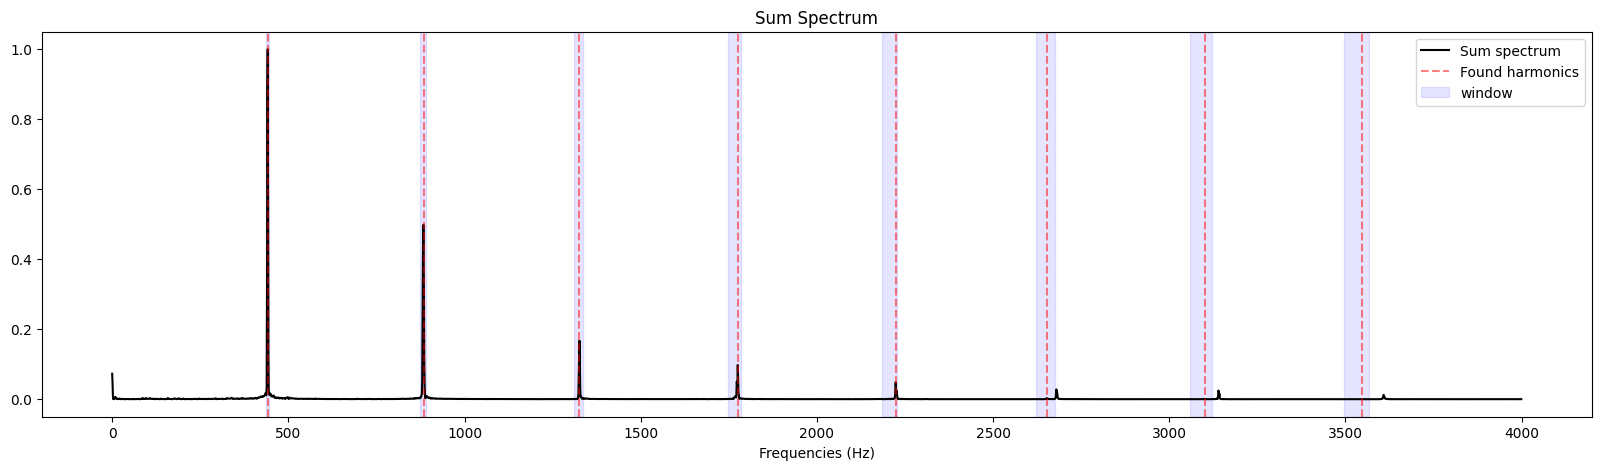

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(frequencies[:Rmax], X_fft[:Rmax], color="k", label="Sum spectrum")
ax.set_xlabel("Frequencies (Hz)")

for i, (harmonic, search_window) in enumerate(zip(harmonics, windows)):
    ax.axvline(harmonic, color="red", linestyle="--", alpha=0.5, label="Found harmonics" if i == 0 else None)
    ax.axvspan(*search_window, alpha=0.1, color="blue", label="window" if i == 0 else None)

ax.legend(loc="upper right")
ax.set_title("Sum Spectrum")
plt.show()

<h3>3.1 Harmonics suppression

In [27]:
def eliminate_harmonics_from_spectrum(X_fft,detected_harmonics, delta_f= df, peak_width = width):
    modified_spectrum = np.copy(X_fft)
    for harmonic_freq in detected_harmonics:
        lower_bound = max(int(harmonic_freq - peak_width), 0)
        upper_bound = min(int(harmonic_freq + peak_width), len(modified_spectrum))
        lower_idx = f2idx(lower_bound, delta_f)
        upper_idx = f2idx(upper_bound, delta_f)
        spectral_region = modified_spectrum[lower_idx:upper_idx]
        min_value_in_region = np.min(spectral_region)
        modified_spectrum[lower_idx:upper_idx] = min_value_in_region

    return modified_spectrum


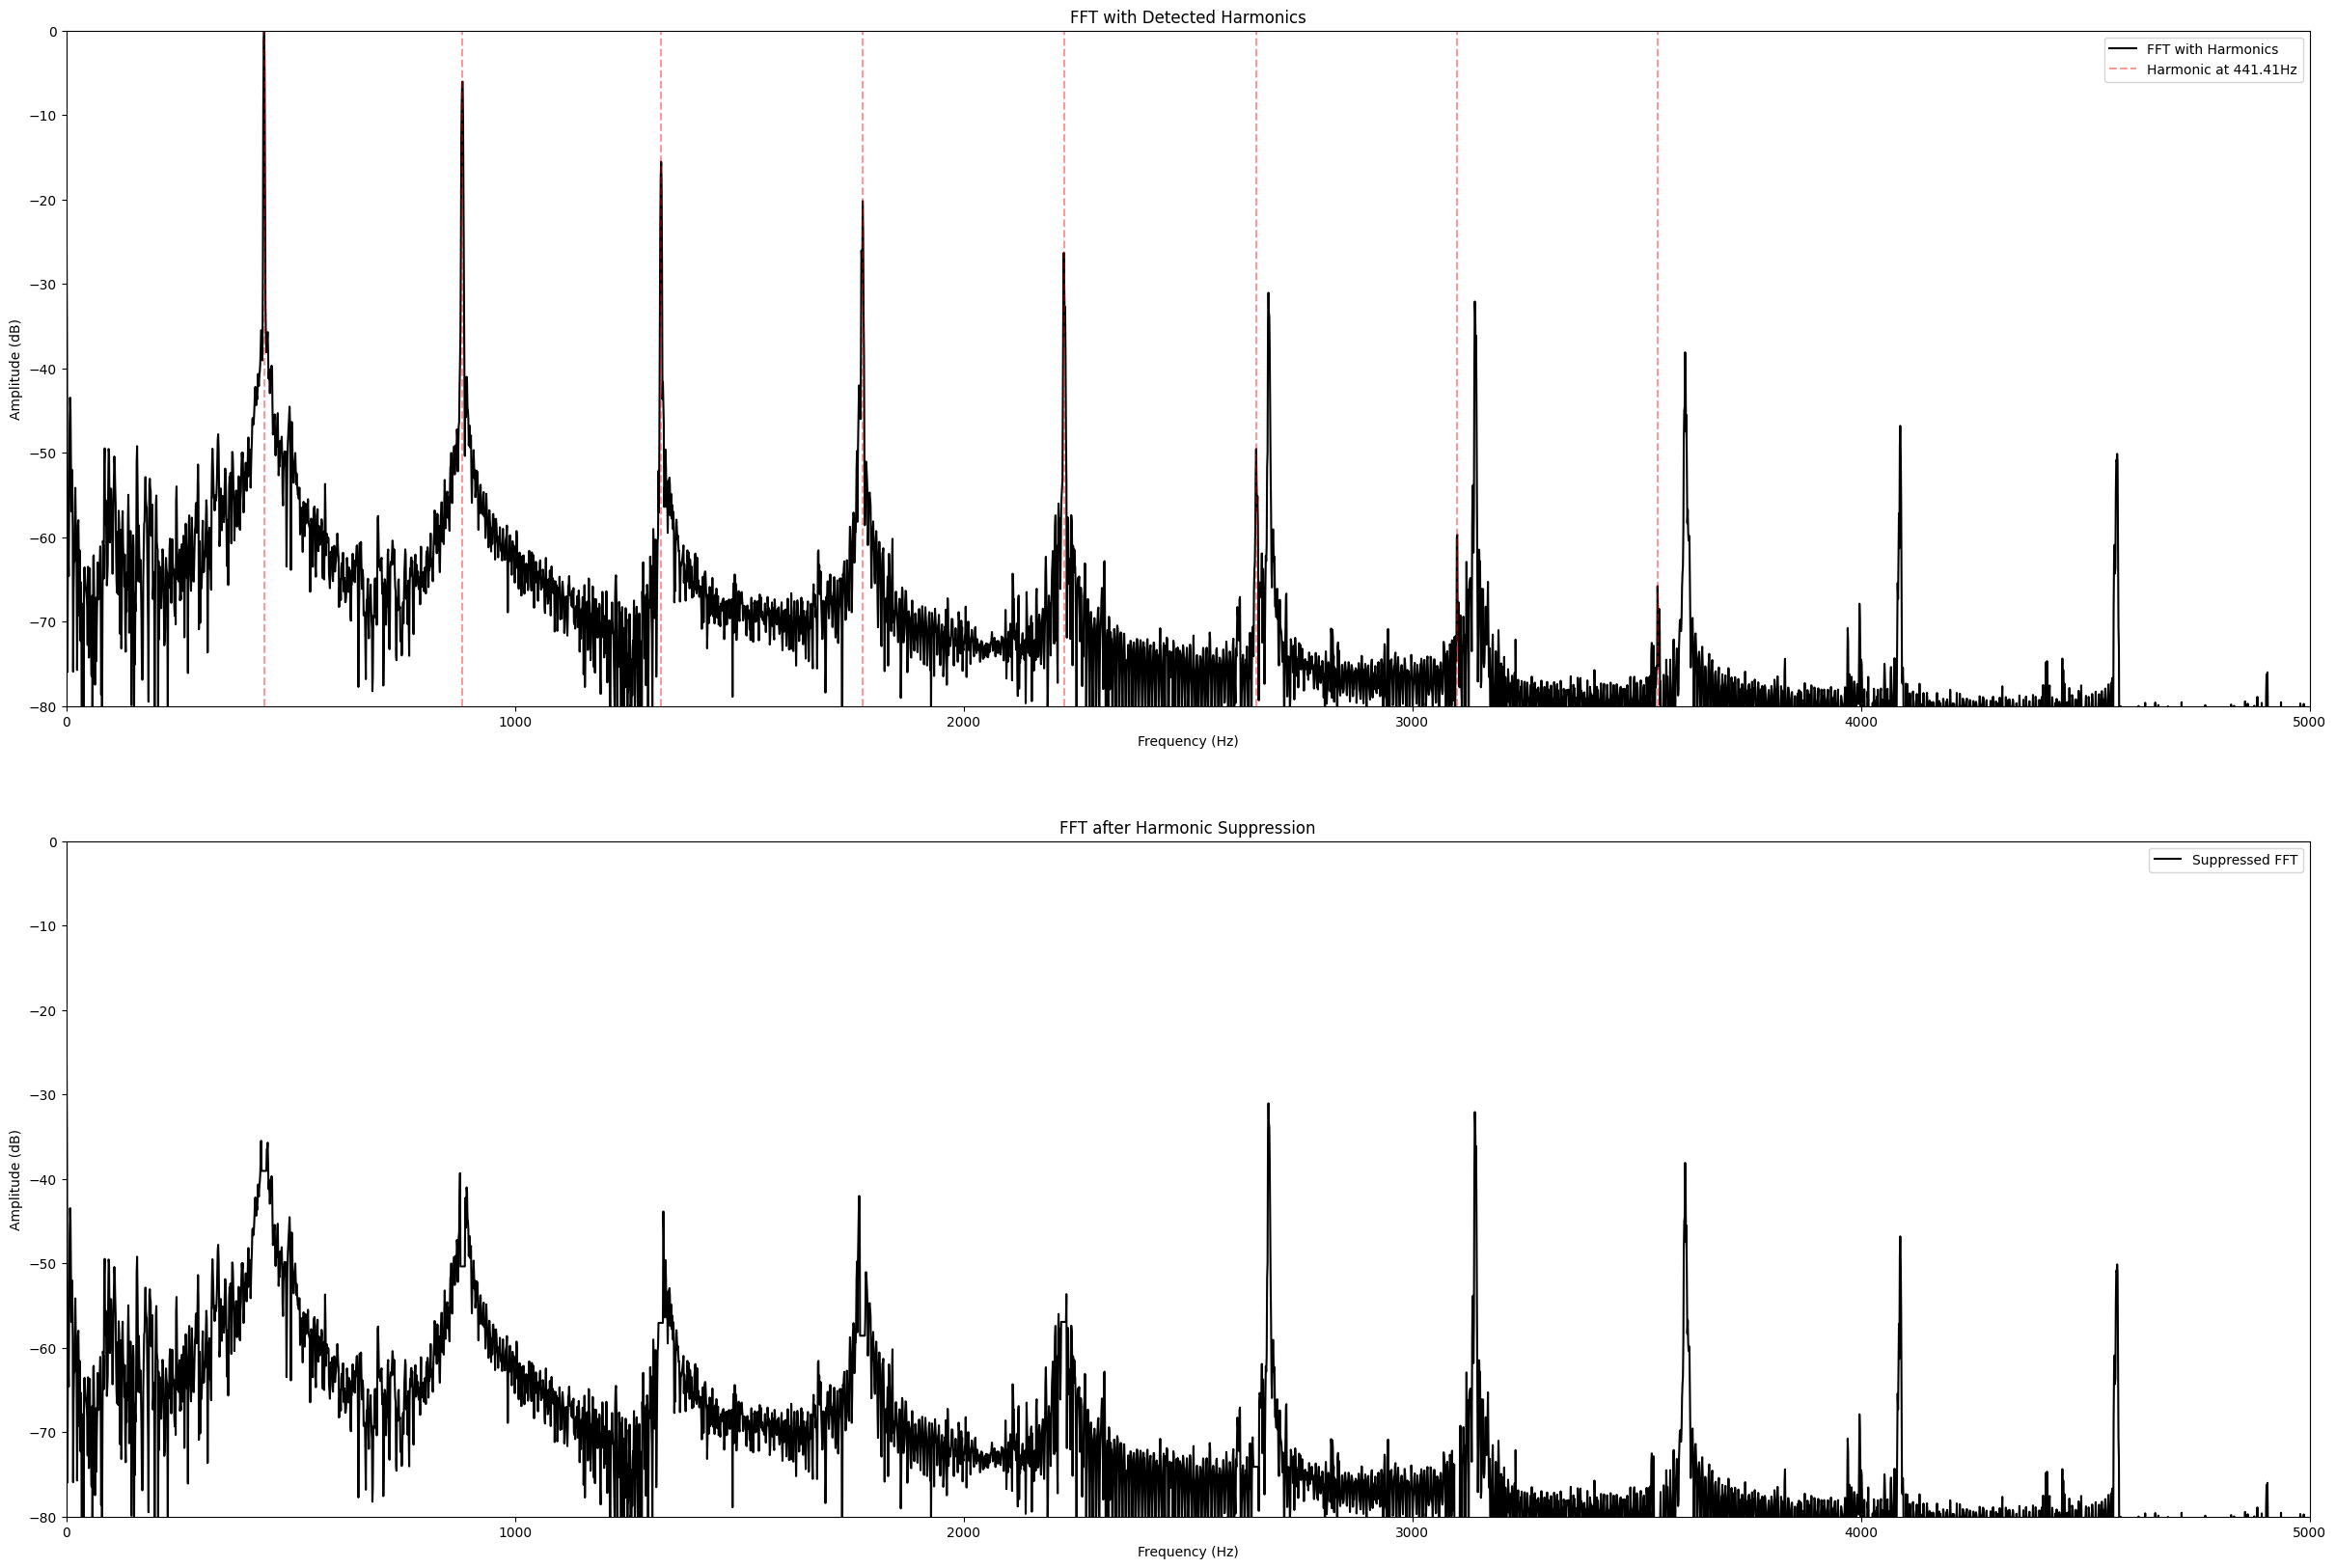

In [28]:
detected_harmonics, _= get_harmonic(spect_sum, frequencies,X_fft, alpha)
suppressed_fft = eliminate_harmonics_from_spectrum(X_fft=X_fft,detected_harmonics=detected_harmonics)
# Plotting
fig, plot_axes = plt.subplots(2, figsize=(30, 20))

# Detected Harmonics plot
plot_axes[0].plot(frequencies[:Nfft // 2], 20 * np.log10(X_fft[:Nfft // 2]), 'k', label="FFT with Harmonics")
for idx, harmonic_freq in enumerate(detected_harmonics):
    
    label = f"Harmonic at {harmonic_freq:.2f}Hz" if idx == 0 else None
    plot_axes[0].axvline(harmonic_freq, color='red', linestyle='--', alpha=0.4, label=label)
plot_axes[0].set_title("FFT with Detected Harmonics")

# Cleaned FFT plot
plot_axes[1].plot(frequencies[:Nfft // 2], 20 * np.log10(suppressed_fft[:Nfft // 2]), 'k', label="Suppressed FFT")
plot_axes[1].set_title("FFT after Harmonic Suppression")

# Set common properties for all subplots
for ax in plot_axes:
    ax.set_xlim(0, 5000)
    ax.set_ylim(-80, 0)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude (dB)")
    ax.legend(loc="upper right")

plt.show()